<a href="https://colab.research.google.com/github/PsorTheDoctor/Sekcja-SI/blob/master/computer_vision/depth_estimation/depth_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Monocular depth estimation

In [ ]:
import os
import sys
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

tf.random.set_seed(123)

In [ ]:
annotation_folder = '/dataset/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file(
      'val.tar.gz',
      cache_subdir=os.path.abspath('.'),
      origin='http://diode-dataset.s3.amazonaws.com/val.tar.gz',
      extract=True
  )

2774638592/2774625282 [==============================] - 60s 0us/step


In [ ]:
path = 'val/outdoor'
filelist = []

for root, dirs, files in os.walk(path):
  for file in files:
    filelist.append(os.path.join(root, file))

filelist.sort()
data = {
    'image': [x for x in filelist if x.endswith('.png')],
    'depth': [x for x in filelist if x.endswith('_depth.npy')],
    'mask': [x for x in filelist if x.endswith('_depth_mask.npy')]
}
df = pd.DataFrame(data)
df = df.sample(frac=1, random_state=42)

In [ ]:
HEIGHT = 256
WIDTH = 256
LR = 0.0002
EPOCHS = 30
BATCH_SIZE = 32

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, data, batch_size=6, dim=(768, 1024), n_channels=3, shuffle=True):
    self.data = data
    self.indices = self.data.index.tolist()
    self.dim = dim
    self.n_channels = n_channels
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.min_depth = 0.1
    self.on_epoch_end()

  def __len__(self):
    return int(np.ceil(len(self.data) / self.batch_size))

  def __getitem__(self, index):
    if (index + 1) * self.batch_size > len(self.indices):
      self.batch_size = len(self.indices) - index * self.batch_size
    
    index = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
    batch = [self.indices[k] for k in index]
    x, y = self.data_generation(batch)
    return x, y

  def on_epoch_end(self):
    self.index = np.arange(len(self.indices))
    if self.shuffle:
      np.random.shuffle(self.index)

  def load(self, img_path, depth_map, mask):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, self.dim)
    img = tf.image.convert_image_dtype(img, tf.float32)

    depth_map = np.load(depth_map).squeeze()

    mask = np.load(mask)
    mask = mask > 0

    max_depth = min(300, np.percentile(depth_map, 99))
    depth_map = np.clip(depth_map, self.min_depth, max_depth)
    depth_map = np.log(depth_map, where=mask)

    depth_map = np.ma.masked_where(~mask, depth_map)

    depth_map = np.clip(depth_map, 0.1, np.log(max_depth))
    depth_map = cv2.resize(depth_map, self.dim)
    depth_map = np.expand_dims(depth_map, axis=2)
    depth_map = tf.image.convert_image_dtype(depth_map, tf.float32)

    return img, depth_map

  def data_generation(self, batch):
    x = np.empty((self.batch_size, *self.dim, self.n_channels))
    y = np.empty((self.batch_size, *self.dim, 1))

    for i, batch_id in enumerate(batch):
      x[i,], y[i,] = self.load(
          self.data['image'][batch_id],
          self.data['depth'][batch_id],
          self.data['mask'][batch_id]
      )
    return x, y

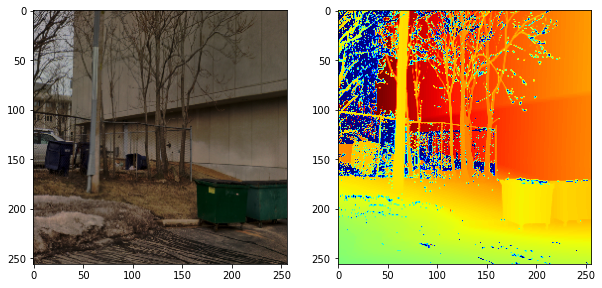

In [ ]:
def visualize_depth_map(samples, test=False, model=None):
    input, target = samples
    cmap = plt.cm.jet
    cmap.set_bad(color='black')

    if test:
        pred = model.predict(input)
        fig, ax = plt.subplots(1, 3, figsize=(10, 10))
        ax[0].imshow((input[0].squeeze()))
        ax[1].imshow((target[0].squeeze()), cmap=cmap)
        ax[2].imshow((pred[0].squeeze()), cmap=cmap)

    else:
        fig, ax = plt.subplots(1, 2, figsize=(10, 10))
        ax[0].imshow((input[0].squeeze()))
        ax[1].imshow((target[0].squeeze()), cmap=cmap)


visualize_samples = next(
    iter(DataGenerator(data=df, batch_size=6, dim=(HEIGHT, WIDTH)))
)
visualize_depth_map(visualize_samples)

In [ ]:
print(visualize_samples[1][1].shape)
print(visualize_samples[0][1].shape)

(256, 256, 1)
(256, 256, 3)


In [ ]:
depth_vis = np.flipud(visualize_samples[1][1].squeeze())
img_vis = np.flipud(visualize_samples[0][1].squeeze())

def show_projection(depth, img):
  fig = plt.figure(figsize=(15, 10))
  ax = plt.axes(projection='3d')

  STEP = 3
  for x in range(0, img.shape[0], STEP):
    for y in range(0, img.shape[1], STEP):
      ax.scatter(
          [depth[x, y]] * 3,
          [y] * 3,
          [x] * 3,
          c=tuple(img[x, y, :3] / 255),
          s=3
      )
    ax.view_init(45, 135)

In [ ]:
class DownscaleBlock(layers.Layer):
  def __init__(
      self, filters, kernel_size=(3, 3), padding='same', strides=1, **kwargs
  ):
    super().__init__(**kwargs)
    self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
    self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
    self.reluA = layers.LeakyReLU(alpha=0.2)
    self.reluB = layers.LeakyReLU(alpha=0.2)
    self.bn2a = tf.keras.layers.BatchNormalization()
    self.bn2b = tf.keras.layers.BatchNormalization()

    self.pool = layers.MaxPool2D((2, 2), (2, 2))

  def call(self, input_tensor):
    d = self.convA(input_tensor)
    x = self.bn2a(d)
    x = self.reluA(x)

    x = self.convB(x)
    x = self.bn2b(x)
    x = self.reluB(x)

    x += d
    p = self.pool(x)
    return x, p


class UpscaleBlock(layers.Layer):
  def __init__(
      self, filters, kernel_size=(3, 3), padding='same', strides=1, **kwargs
  ):
    super().__init__(**kwargs)
    self.us = layers.UpSampling2D((2, 2))
    self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
    self.convB = layers.Conv2D(filters, kernel_size, strides, padding) 
    self.reluA = layers.LeakyReLU(alpha=0.2)
    self.reluB = layers.LeakyReLU(alpha=0.2)
    self.bn2a = tf.keras.layers.BatchNormalization()
    self.bn2b = tf.keras.layers.BatchNormalization()
    self.conc = layers.Concatenate()

  def call(self, x, skip):
    x = self.us(x)
    concat = self.conc([x, skip])
    x = self.convA(concat)
    x = self.bn2a(x)
    x = self.reluA(x)

    x = self.convB(x)
    x = self.bn2b(x)
    x = self.reluB(x)
    return x


class BottleNeckBlock(layers.Layer):
  def __init__(
      self, filters, kernel_size=(3, 3), padding='same', strides=1, **kwargs
  ):
    super().__init__(**kwargs)
    self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
    self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
    self.reluA = layers.LeakyReLU(alpha=0.2)
    self.reluB = layers.LeakyReLU(alpha=0.2)

  def call(self, x):
    x = self.convA(x)
    x = self.reluA(x)
    x = self.convB(x)
    x = self.reluB(x)
    return x

In [ ]:
class DepthEstimationModel(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.ssim_loss_weight = 0.85
    self.l1_loss_weight = 0.1
    self.edge_loss_weight = 0.9
    self.loss_metric = tf.keras.metrics.Mean(name='loss')
    f = [16, 32, 64, 128, 256]
    self.downscale_blocks = [
        DownscaleBlock(f[0]),
        DownscaleBlock(f[1]),
        DownscaleBlock(f[2]),
        DownscaleBlock(f[3])
    ]
    self.bottle_neck_block = BottleNeckBlock(f[4])
    self.upscale_blocks = [
        UpscaleBlock(f[3]),
        UpscaleBlock(f[2]),
        UpscaleBlock(f[1]),
        UpscaleBlock(f[0])          
    ]
    self.conv_layer = layers.Conv2D(1, (1, 1), padding='same', activation='tanh')
  
  def calculate_loss(self, target, pred):
    dy_true, dx_true = tf.image.image_gradients(target)
    dy_pred, dx_pred = tf.image.image_gradients(pred)
    weights_x = tf.exp(tf.reduce_mean(tf.abs(dx_true)))
    weights_y = tf.exp(tf.reduce_mean(tf.abs(dy_true)))

    smoothness_x = dx_pred * weights_x
    smoothness_y = dy_pred * weights_y

    depth_smoothness_loss = tf.reduce_mean(abs(smoothness_x)) + tf.reduce_mean(
        abs(smoothness_y)
    )
    ssim_loss = tf.reduce_mean(
        1 - tf.image.ssim(
            target, pred, max_val=WIDTH, filter_size=7, k1=0.01 ** 2, k2=0.03 ** 2
        )
    )
    l1_loss = tf.reduce_mean(tf.abs(target - pred))

    loss = (
        (self.ssim_loss_weight * ssim_loss)
        + (self.l1_loss_weight * l1_loss)
        + (self.edge_loss_weight * depth_smoothness_loss)
    )
    return loss

  @property
  def metrics(self):
    return [self.loss_metric]

  def train_step(self, batch_data):
    input, target = batch_data
    with tf.GradientTape() as tape:
      pred = self(input, training=True)
      loss = self.calculate_loss(target, pred)

    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
    self.loss_metric.update_state(loss)
    return {
        'loss': self.loss_metric.result()
    }

  def test_step(self, batch_data):
    input, target = batch_data
    
    pred = self(input, training=True)
    loss = self.calculate_loss(target, pred)

    self.loss_metric.update_state(loss)
    return {
        'loss': self.loss_metric.result()
    }
  
  def call(self, x):
    c1, p1 = self.downscale_blocks[0](x)
    c2, p2 = self.downscale_blocks[1](p1)
    c3, p3 = self.downscale_blocks[2](p2)
    c4, p4 = self.downscale_blocks[3](p3)

    bn = self.bottle_neck_block(p4)

    u1 = self.upscale_blocks[0](bn, c4)
    u2 = self.upscale_blocks[1](u1, c3)
    u3 = self.upscale_blocks[2](u2, c2)
    u4 = self.upscale_blocks[3](u3, c1)

    return self.conv_layer(u4)

In [ ]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LR,
    amsgrad=False
)
model = DepthEstimationModel()

cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none'
)
model.compile(optimizer, loss=cross_entropy)

train_loader = DataGenerator(
    data=df[:260].reset_index(drop='true'), batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH)
)
val_loader = DataGenerator(
    data=df[260:].reset_index(drop='true'), batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH)
)
history = model.fit(
    train_loader,
    epochs=EPOCHS,
    validation_data=val_loader
)

Epoch 1/30
9/9 [==============================] - 42s 4s/step - loss: 1.1355 - val_loss: 0.9510
Epoch 2/30
9/9 [==============================] - 13s 2s/step - loss: 0.9751 - val_loss: 0.8579
Epoch 3/30
9/9 [==============================] - 13s 2s/step - loss: 0.8569 - val_loss: 0.7917
Epoch 4/30
9/9 [==============================] - 13s 2s/step - loss: 0.8265 - val_loss: 0.7617
Epoch 5/30
9/9 [==============================] - 13s 2s/step - loss: 0.8250 - val_loss: 0.7459
Epoch 6/30
9/9 [==============================] - 13s 2s/step - loss: 0.7822 - val_loss: 0.7431
Epoch 7/30
9/9 [==============================] - 13s 2s/step - loss: 0.7663 - val_loss: 0.7356
Epoch 8/30
9/9 [==============================] - 13s 2s/step - loss: 0.7505 - val_loss: 0.7233
Epoch 9/30
9/9 [==============================] - 13s 2s/step - loss: 0.7526 - val_loss: 0.7166
Epoch 10/30
9/9 [==============================] - 13s 2s/step - loss: 0.7264 - val_loss: 0.7075
Epoch 11/30
9/9 [======================

In [ ]:
model.save_weights('depth_estimation.h5')

In [ ]:
model.load_weights('depth_estimation.h5')

Text(0, 0.5, 'Loss')

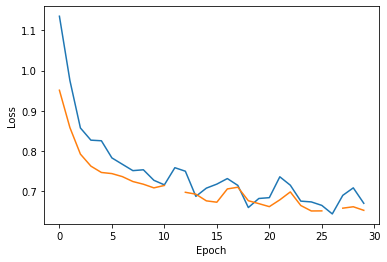

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

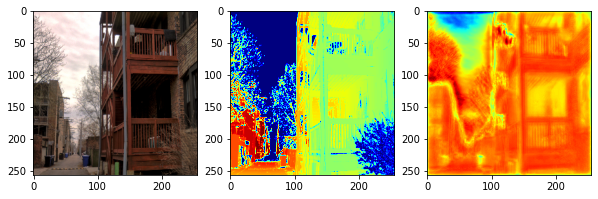

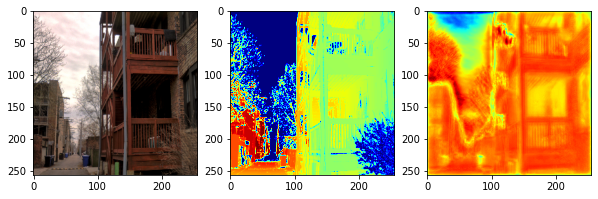

In [ ]:
test_loader = next(
    iter(DataGenerator(
        data=df[1:].reset_index(drop='true'), batch_size=6, dim=(HEIGHT, WIDTH)
    ))
)
visualize_depth_map(test_loader, test=True, model=model)

test_loader = next(
    iter(DataGenerator(
        data=df[1:].reset_index(drop='true'), batch_size=6, dim=(HEIGHT, WIDTH)
    ))
)
visualize_depth_map(test_loader, test=True, model=model)

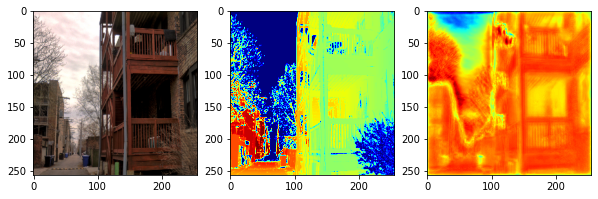

In [ ]:
test_loader = next(
    iter(DataGenerator(
        data=df[1:].reset_index(drop='true'), batch_size=1, dim=(HEIGHT, WIDTH)
    ))
)
visualize_depth_map(test_loader, test=True, model=model)

In [ ]:
!pip install -q huggingface_hub
!git clone https://huggingface.co/keras-io/monocular-depth-estimation

fatal: destination path 'monocular-depth-estimation' already exists and is not an empty directory.


In [ ]:
from huggingface_hub import from_pretrained_keras

model1 = from_pretrained_keras('keras-io/monocular-depth-estimation')

config.json not found in HuggingFace Hub


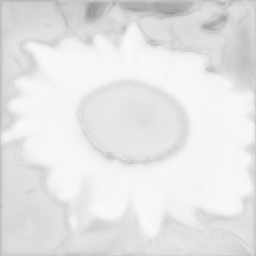

In [ ]:
img = Image.open('sunflower.jpg')
resized = img.resize((256, 256))
array = np.array(resized, np.float32).reshape((1, 256, 256, 3))
array /= 255.0
pred = model.predict(array)
res = np.squeeze(pred)
res *= 255.0

from google.colab.patches import cv2_imshow
cv2_imshow(cv2.cvtColor(res, cv2.COLOR_GRAY2BGR))